In [8]:
pip install ucimlrepo


[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


{'uci_id': 352, 'name': 'Online Retail', 'repository_url': 'https://archive.ics.uci.edu/dataset/352/online+retail', 'data_url': 'https://archive.ics.uci.edu/static/public/352/data.csv', 'abstract': 'This is a transactional data set which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail.', 'area': 'Business', 'tasks': ['Classification', 'Clustering'], 'characteristics': ['Multivariate', 'Sequential', 'Time-Series'], 'num_instances': 541909, 'num_features': 6, 'feature_types': ['Integer', 'Real'], 'demographics': [], 'target_col': None, 'index_col': ['InvoiceNo', 'StockCode'], 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2015, 'last_updated': 'Mon Oct 21 2024', 'dataset_doi': '10.24432/C5BW33', 'creators': ['Daqing Chen'], 'intro_paper': {'ID': 361, 'type': 'NATIVE', 'title': 'Data mining for the online retail industry: A case study of RFM model-based customer segmenta

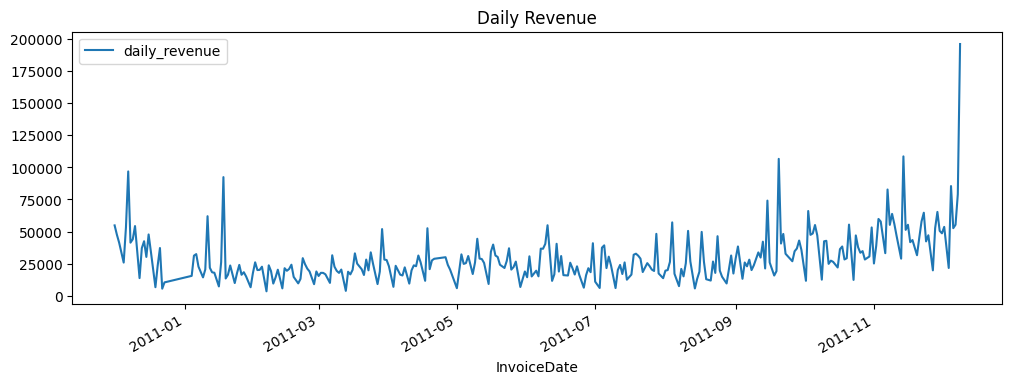

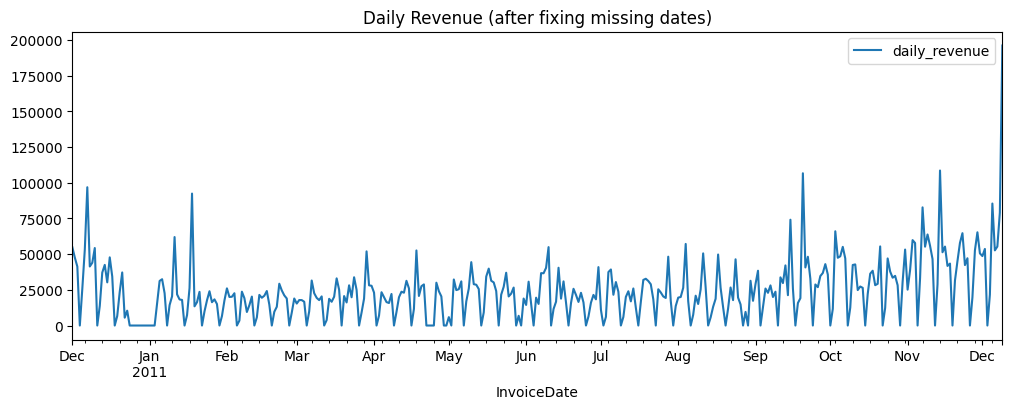

In [27]:
from ucimlrepo import fetch_ucirepo
import pandas as pd

# 1. Fetch dataset
online_retail = fetch_ucirepo(id=352)

X = online_retail.data.features      # features (DataFrame)
y = online_retail.data.targets       # targets (likely None)

print(online_retail.metadata)
print(online_retail.variables)

# 2. Make a working copy and bring index columns out
df = X.copy().reset_index()   # 🔑 this brings InvoiceNo, StockCode into columns
print("Columns:", df.columns)

# -------------------------
# 3. Data preprocessing
# -------------------------

# Convert InvoiceDate to datetime
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])

# Keep only positive quantity & price
df = df[(df["Quantity"] > 0) & (df["UnitPrice"] > 0)].copy()

# Create revenue
df["Revenue"] = df["Quantity"] * df["UnitPrice"]

# Filter United Kingdom transactions
df_uk = df[df["Country"] == "United Kingdom"].copy()

# 4. Create daily revenue time series
daily = (
    df_uk
    .set_index("InvoiceDate")
    .groupby(pd.Grouper(freq="D"))["Revenue"]
    .sum()
    .to_frame(name="daily_revenue")
    .reset_index()
)

# Remove days with zero revenue
daily = daily[daily["daily_revenue"] > 0].copy()

print("First few daily rows:")
print(daily.head())

# -------------------------
# 5. Inspect dataset
# -------------------------

print("\nDaily.info():")
daily.info()

print("\nMissing values per column:")
print(daily.isnull().sum())

print("\nDate range:",
      daily["InvoiceDate"].min(),
      "→",
      daily["InvoiceDate"].max())

# -------------------------
# 6. Look for missing dates
# -------------------------

full_index = pd.date_range(
    start=daily["InvoiceDate"].min(),
    end=daily["InvoiceDate"].max(),
    freq="D"
)

missing_dates = full_index.difference(daily["InvoiceDate"])
print("\nFirst few missing dates:", missing_dates[:10])

# Plot original (gappy) series
daily.plot(
    x="InvoiceDate",
    y="daily_revenue",
    figsize=(12, 4),
    title="Daily Revenue"
)

# -------------------------
# 7. Fix missing dates (time series continuity)
# -------------------------

daily = (
    daily
    .set_index("InvoiceDate")
    .asfreq("D", fill_value=0)
    .reset_index()
)

daily.plot(
    x="InvoiceDate",
    y="daily_revenue",
    figsize=(12, 4),
    title="Daily Revenue (after fixing missing dates)"
)

# -------------------------
# 8. Create predictors (features)
# -------------------------

# Weekday features
daily["weekday"] = daily["InvoiceDate"].dt.weekday
daily["is_weekend"] = daily["weekday"].isin([5, 6]).astype(int)

# Month
daily["month"] = daily["InvoiceDate"].dt.month

# Toy "promotion" flag: top 10% highest revenue days
threshold = daily["daily_revenue"].quantile(0.9)
daily["is_promotion"] = (daily["daily_revenue"] >= threshold).astype(int)

# -------------------------
# 9. Daily number of transactions
# -------------------------

tx_per_day = (
    df_uk
    .groupby(pd.Grouper(key="InvoiceDate", freq="D"))["CustomerID"]
    .nunique()
    .reset_index(name="num_transactions")
)

# When merging with daily (which already has all dates),
# missing num_transactions will become NaN; fill with 0 after merge if needed.

daily = daily.merge(tx_per_day, on="InvoiceDate", how="left")
daily["num_transactions"] = daily["num_transactions"].fillna(0)

print("\nFinal daily head:")
print(daily.head())

print("\nFinal daily.info():")
print(daily.info())

# 10. Save for R
daily.to_csv("uk_daily_features.csv", index=False)
print("\nSaved uk_daily_features.csv – now switch to R.")


In [26]:
df_uk.columns

Index(['index', 'Description', 'Quantity', 'InvoiceDate', 'UnitPrice',
       'CustomerID', 'Country', 'Revenue'],
      dtype='object')